In [1]:
import os
import zipfile
import cv2
from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image

In [2]:
# Config file
RAW_PATH = "../../data/raw"
PROCESSED_PATH = "../../data/processed"
TRAIN_CHECKPOINT_PATH = "../../checkpoints/train_models/"
TEST_CHECKPOINT_PATH = "../../checkpoints/best_model/"
TRAIN_IMAGES_PATH = "../../outputs/train_images/"


In [3]:
# Utils file
import joblib

def dump(value = None, filename = None):
    if value is not None and filename is not None:
        joblib.dump(value=value, filename=filename)
        
    else:
        raise ValueError("value and filename cannot be None".capitalize())

def load(filename):
    if os.path.exists(filename):
        return joblib.load(filename=filename)
    else:
        raise Exception("File not found".capitalize())

def define_device(device = "mps"):
    if device == "mps":
        return torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    elif device == "cuda":
        return torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        return torch.device("cpu")

def weight_init(m):
    classname = m.__class__.__name__

    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [20]:
class Loader:
    def __init__(self, image_path = None, image_size = 256, batch_size = 4, split_ratio = 0.25):
        self.image_path = image_path
        self.image_size = image_size
        self.batch_size = batch_size
        self.split_ratio = split_ratio
        
        self.base_images = list()
        self.mask_images = list()

    def base_transforms(self):
        return transforms.Compose([
            transforms.Resize((self.image_size,self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

    def mask_transforms(self):
        return transforms.Compose([
            transforms.Resize((self.image_size,self.image_size)),
            transforms.ToTensor(),
            transforms.Grayscale(num_output_channels=1),
            transforms.Normalize([0.5], [0.5])
        ])

    def unzip_folder(self):
        if os.path.exists(RAW_PATH):
            with zipfile.ZipFile(self.image_path, "r") as zip_ref:
                zip_ref.extractall(os.path.join(RAW_PATH, "segmented"))
        else:
            raise Exception("Raw data folder not found".capitalize())

    def process_segmented_data(self):
        if os.path.join(RAW_PATH, "segmented"):
            self.images_directory = os.path.join(RAW_PATH, "segmented")

            self.base_directory = os.path.join(
                self.images_directory, os.listdir(self.images_directory)[0]
            )
            self.mask_directory = os.path.join(
                self.images_directory, os.listdir(self.images_directory)[1]
            )

            self.categories = os.listdir(self.base_directory)

            for category in self.categories:
                base_folder_path = os.path.join(self.base_directory, category)
                mask_folder_path = os.path.join(self.mask_directory, category)

                for image in os.listdir(base_folder_path):
                    if image in os.listdir(mask_folder_path):
                        self.base_images.append(
                            self.base_transforms()(
                                Image.fromarray(
                                    cv2.imread(os.path.join(base_folder_path, image))
                                )
                            )
                        )
                        self.mask_images.append(
                            self.mask_transforms()(
                                Image.fromarray(
                                    cv2.imread(os.path.join(mask_folder_path, image))
                                )
                            )
                        )

            return self.base_images, self.mask_images
        else:
            raise Exception(
                "Segmented data folder not found in the raw folder".capitalize()
            )

    def create_dataloader(self):
        images, masks = self.process_segmented_data()
        data_split = train_test_split(images, masks, test_size=self.split_ratio, random_state=42)

        train_dataloader = DataLoader(
            dataset=list(zip(data_split[0], data_split[2])),
            batch_size=self.batch_size,
            shuffle=True,
        )
        val_dataloader = DataLoader(
            dataset=list(zip(data_split[1], data_split[3])),
            batch_size=self.batch_size * 6,
            shuffle=True,
        )

        try:
            if os.path.exists(PROCESSED_PATH):
                dump(value=train_dataloader, filename=os.path.join(PROCESSED_PATH, "train_dataloader.pkl"))
                dump(value=val_dataloader, filename=os.path.join(PROCESSED_PATH, "test_dataloader.pkl"))
            else:
                raise Exception("Processed data folder not found".capitalize())

        except ValueError as e:
            print("Exception caught in the section - {}".format(e).capitalize())
            
    @staticmethod
    def show_images():
        if os.path.exists(PROCESSED_PATH):
            val_images, val_masks = next(iter(load(filename="../../data/processed/test_dataloader.pkl")))
    
            plt.figure(figsize=(30, 20))
            
            for index, image in enumerate(val_images):
                plt.subplot(2 * 4, 2 * 6, 2 * index + 1)
                image = image.permute(1, 2, 0)
                image = (image - image.min())/(image.max() - image.min())
                plt.imshow(image)
                plt.title("Image")
                plt.axis("off")
                
                plt.subplot(2*4, 2*6, 2*index + 2)
                masks = val_masks[index].permute(1, 2, 0)
                masks = (masks - masks.min())/(masks.max() - masks.min())
                plt.imshow(masks, cmap="gray")
                plt.title("Mask")
                plt.axis("off")
                
            plt.tight_layout()
            plt.show()
            
        else:
            raise Exception("Processed data folder not found".capitalize())

In [18]:
loader = Loader(image_path="/Users/shahmuhammadraditrahman/Desktop/cell.zip", batch_size=4)
loader.unzip_folder()
loader.create_dataloader()

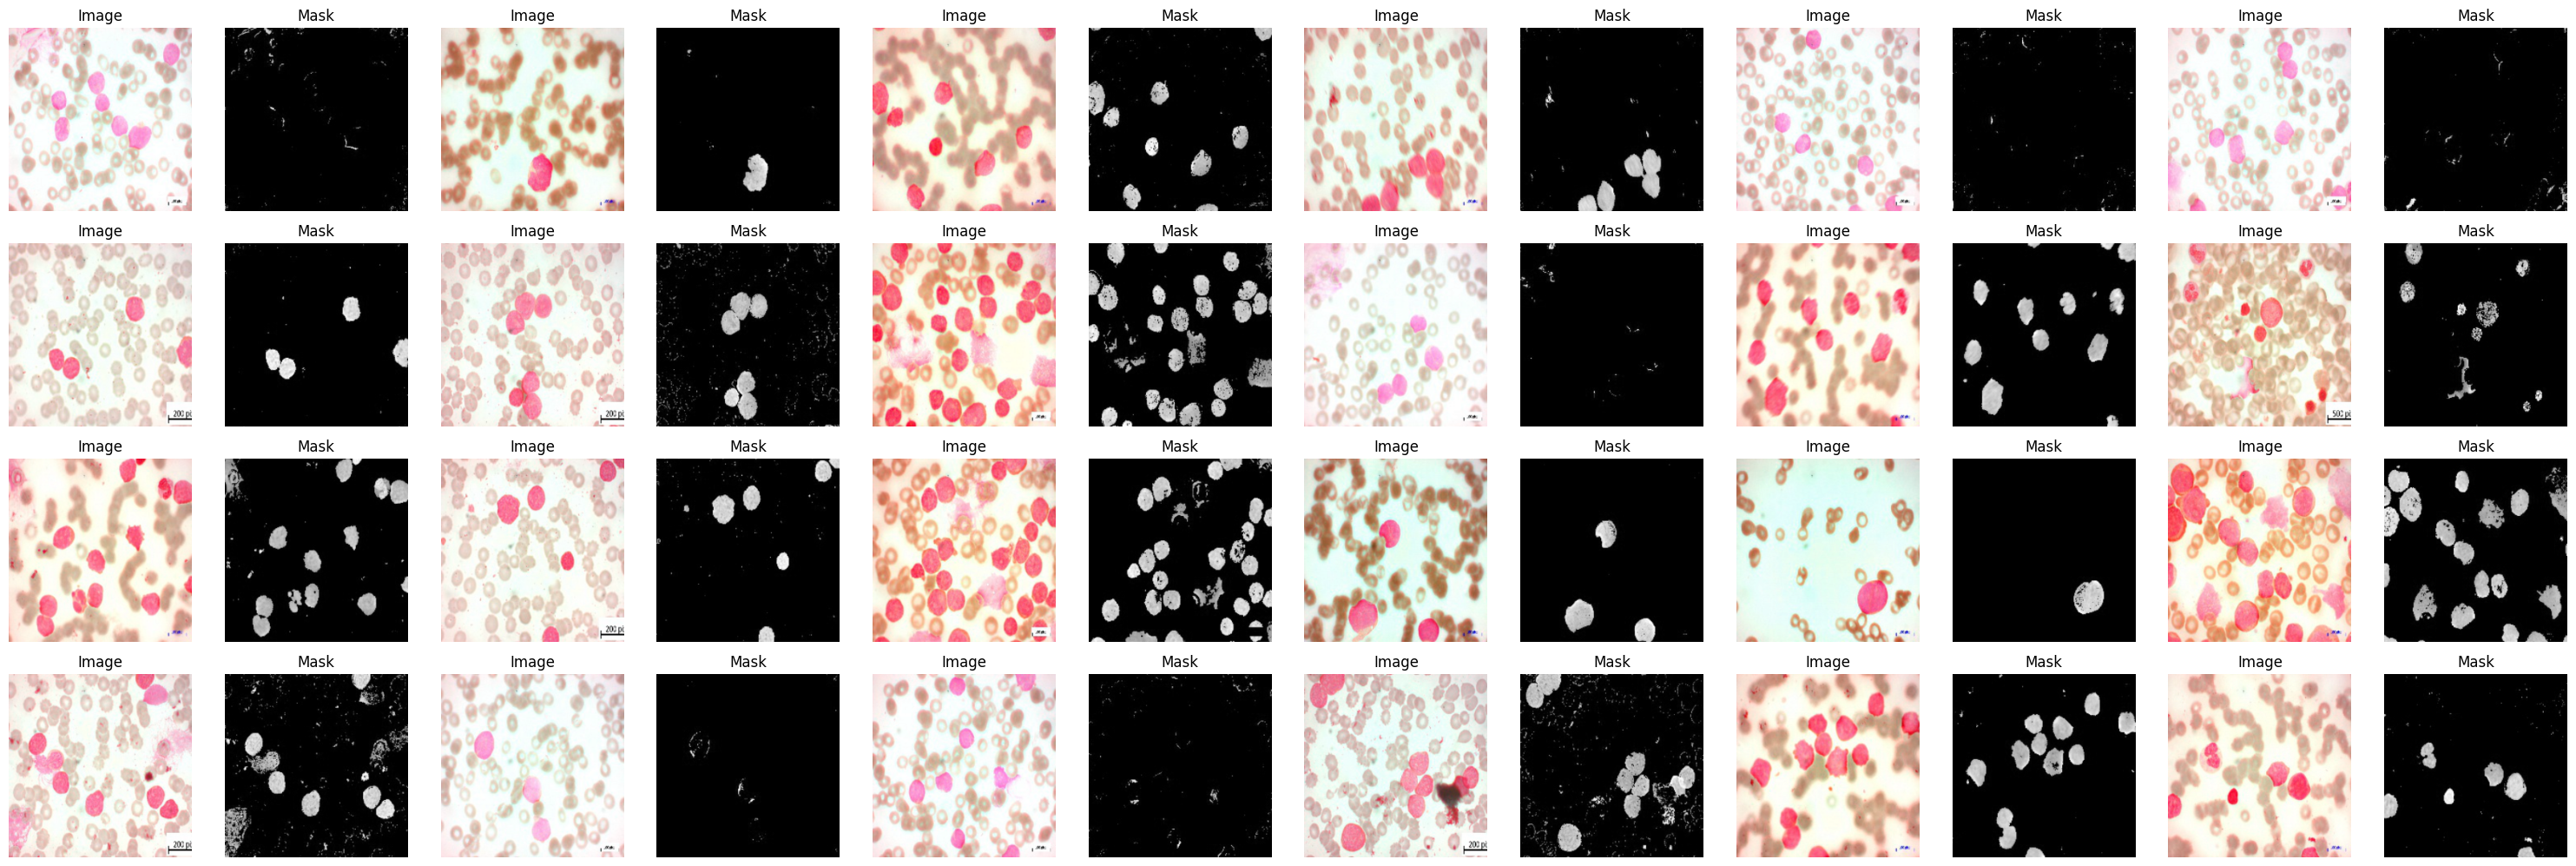

In [21]:
# To display the images
Loader.show_images()

In [15]:
train_dataloader = load(os.path.join(PROCESSED_PATH, "train_dataloader.pkl"))
val_dataloader = load(os.path.join(PROCESSED_PATH, "test_dataloader.pkl"))

In [16]:
train_images, train_masks = next(iter(train_dataloader))
val_images, val_masks = next(iter(val_dataloader))

print(train_images.shape, train_masks.shape)
print(val_images.shape, val_masks.shape)

torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
torch.Size([24, 3, 256, 256]) torch.Size([24, 1, 256, 256])


In [4]:
class Encoder(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(Encoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.model = self.encoder_block()

    def encoder_block(self):
        layers = OrderedDict()
        layers["conv1"] = nn.Conv2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        layers["relu1"] = nn.ReLU(inplace=True)
        layers["conv2"] = nn.Conv2d(
            in_channels=self.out_channels,
            out_channels=self.out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
        )
        layers["batch_norm1"] = nn.BatchNorm2d(self.out_channels)
        layers["relu2"] = nn.ReLU(inplace=True)

        return nn.Sequential(layers)

    def forward(self, x):
        return self.model(x) if x is not None else None


if __name__ == "__main__":
    encoder = Encoder(in_channels=3, out_channels=64)
    assert encoder(torch.randn(64, 3, 256, 256)).shape == (64, 64, 256, 256)

In [5]:
class Decoder(nn.Module):
    def __init__(self, in_channels=None, out_channels=None):
        super(Decoder, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.model = self.decoder_block()

    def decoder_block(self):
        layers = OrderedDict()
        layers["deconv1"] = nn.ConvTranspose2d(
            in_channels=self.in_channels,
            out_channels=self.out_channels,
            kernel_size=2,
            stride=2,
        )
        return nn.Sequential(layers)

    def forward(self, x, skip_info):
        if x is not None and skip_info is not None:
            return torch.cat((self.model(x), skip_info), dim=1)
        else:
            raise ValueError("Input and skip_info cannot be None".capitalize())


if __name__ == "__main__":
    encoder = Encoder(in_channels=3, out_channels=64)
    decoder = Decoder(in_channels=64, out_channels=64)

    skip_info = encoder(torch.randn(64, 3, 256, 256))
    noise_samples = torch.randn(64, 64, 128, 128)

    assert decoder(noise_samples, skip_info).shape == (64, 128, 256, 256)

In [6]:
import torch.nn as nn


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder_layer1 = Encoder(in_channels=3, out_channels=64)
        self.encoder_layer2 = Encoder(in_channels=64, out_channels=128)
        self.encoder_layer3 = Encoder(in_channels=128, out_channels=256)
        self.encoder_layer4 = Encoder(in_channels=256, out_channels=512)
        self.bottom_layer = Encoder(in_channels=512, out_channels=1024)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.intermediate_layer1 = Encoder(in_channels=1024, out_channels=512)
        self.intermediate_layer2 = Encoder(in_channels=512, out_channels=256)
        self.intermediate_layer3 = Encoder(in_channels=256, out_channels=128)
        self.intermediate_layer4 = Encoder(in_channels=128, out_channels=64)

        self.decoder_layer1 = Decoder(in_channels=1024, out_channels=512)
        self.decoder_layer2 = Decoder(in_channels=512, out_channels=256)
        self.decoder_layer3 = Decoder(in_channels=256, out_channels=128)
        self.decoder_layer4 = Decoder(in_channels=128, out_channels=64)

        self.final_layer = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1), nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder path
        enc1_out = self.encoder_layer1(x)
        pooled_enc1 = self.max_pool(enc1_out)

        enc2_out = self.encoder_layer2(pooled_enc1)
        pooled_enc2 = self.max_pool(enc2_out)

        enc3_out = self.encoder_layer3(pooled_enc2)
        pooled_enc3 = self.max_pool(enc3_out)

        enc4_out = self.encoder_layer4(pooled_enc3)
        pooled_enc4 = self.max_pool(enc4_out)

        bottom_out = self.bottom_layer(pooled_enc4)

        # Decoder path
        dec1_input = self.decoder_layer1(bottom_out, enc4_out)
        dec1_out = self.intermediate_layer1(dec1_input)

        dec2_input = self.decoder_layer2(dec1_out, enc3_out)
        dec2_out = self.intermediate_layer2(dec2_input)

        dec3_input = self.decoder_layer3(dec2_out, enc2_out)
        dec3_out = self.intermediate_layer3(dec3_input)

        dec4_input = self.decoder_layer4(dec3_out, enc1_out)
        dec4_out = self.intermediate_layer4(dec4_input)

        # Final output
        final_output = self.final_layer(dec4_out)

        return final_output

In [7]:
# Define the dice loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=0.01):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return dice_loss

In [8]:
from tqdm import tqdm

In [31]:
import logging
import numpy as np

class Trainer:
    def __init__(self, epochs = 10, lr = 0.0002, loss = "dice", smooth_value = 0.01, beta1 = 0.5, device = "mps", display = True):
        self.epochs = epochs
        self.lr = lr
        self.loss = loss
        self.smooth_value = smooth_value
        self.beta1 = beta1
        self.beta2 = 0.999
        self.weight_decay = 1e-4
        self.device = device
        self.is_display = display
        self.history = {"train_loss": list(), "test_loss": list()}

    def __setup__(self):
        self.device = define_device(device=self.device)
        self.model = UNet().to(self.device)
        self.model.apply(weight_init)
        self.loss = self.select_loss_function()
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))

        if os.path.exists(PROCESSED_PATH):
            self.train_dataloader = load(filename=os.path.join(PROCESSED_PATH, "train_dataloader.pkl"))
            self.test_dataloader = load(filename=os.path.join(PROCESSED_PATH, "test_dataloader.pkl"))
        else:
            raise ValueError("Processed data not found. Please run the preprocessing notebook.".capitalize())

    def select_loss_function(self):
        if self.loss == "dice":
            return DiceLoss(smooth=0.01)

    def l1_loss(self, model, lambda_value = 0.01):
        return lambda_value * sum(
            (torch.norm(input=params, p=1) for params in model.parameters()))

    def l2_loss(self, model, lambda_value = 0.01):
        return lambda_value * sum(
            (torch.norm(input=params, p=2) for params in model.parameters()))

    def update_training_loss(self, **kwargs):
        self.optimizer.zero_grad()

        train_predicted_masks = self.model(kwargs["images"])
        train_predicted_loss = self.loss(train_predicted_masks, kwargs["masks"])

        train_predicted_loss.backward(retain_graph=True)
        self.optimizer.step()

        return train_predicted_loss.item()

    def update_testing_loss(self, **kwargs):
        test_predicted_masks = self.model(kwargs["images"])
        test_predicted_loss = self.loss(test_predicted_masks, kwargs["masks"])

        return test_predicted_loss.item()

    def saved_checkpoints(self, **kwargs):
        if kwargs["epoch"] != self.epochs:
            if os.path.exists(TRAIN_CHECKPOINT_PATH):
                torch.save(
                    self.model.state_dict(), os.path.join(TRAIN_CHECKPOINT_PATH, "model_{}.pth".format(kwargs["epoch"]+1)))
        else:
            if os.path.exists(TEST_CHECKPOINT_PATH):
                torch.save(self.model.state_dict(), os.path.join(TEST_CHECKPOINT_PATH, "best_model.pth"))

    def show_progress(self, **kwargs):
        if self.is_display == True:
            print("Epochs: [{}/{}] - train_loss: [{:.5f}] - test_loss: [{:.5f}]".format(
                kwargs["epoch"],
                kwargs["epochs"],
                kwargs["train_loss"],
                kwargs["test_loss"]))
        elif self.is_display == False:
            logging.info(
                "Epochs: [{}/{}] - train_loss: [{:.5f}] - test_loss: [{:.5f}]".format(
                    kwargs["epoch"],
                    kwargs["epochs"],
                    kwargs["train_loss"],
                    kwargs["test_loss"],
                )
            )

    def train(self):
        try:
            self.__setup__()
        except Exception as e:
            print("The exception in the section # {}".format(e).capitalize())
        else:
            self.model.train()
            for epoch in tqdm(range(self.epochs)):
                train_loss = list()
                test_loss = list()

                for _, (images, masks) in enumerate(self.train_dataloader):
                    images = images.to(self.device)
                    masks = masks.to(self.device)

                    train_loss.append(self.update_training_loss(images=images, masks=masks))

                self.model.eval()
                
                for _, (images, masks) in enumerate(self.test_dataloader):
                    images = images.to(self.device)
                    masks = masks.to(self.device)

                    test_loss.append(self.update_testing_loss(images=images, masks=masks))

                try:
                    self.saved_checkpoints(epoch=epoch+1)
                    
                    self.history["train_loss"].append(np.mean(train_loss))
                    self.history["test_loss"].append(np.mean(test_loss))
                    
                except Exception as e:
                    print(e)
                else:
                    images, _ = next(iter(self.test_dataloader))
                    predicted_masks = self.model(images.to(self.device))
                    if os.path.exists(TRAIN_IMAGES_PATH):
                        save_image(
                            predicted_masks,
                            os.path.join(TRAIN_IMAGES_PATH, "train_masks_{}.png".format(epoch+1)),
                            nrow=6,
                            normalize=True,
                        )
                    else:
                        raise Exception("Train images path not found.".capitalize())
                finally:
                    self.show_progress(
                        epoch=epoch+1,
                        epochs=self.epochs,
                        train_loss=np.mean(train_loss),
                        test_loss=np.mean(test_loss),
                    )

In [ ]:
if __name__ == "__main__":
    trainer = Trainer(epochs=1, lr=0.0002, loss="dice", smooth_value=0.01, beta1=0.5, device="mps")
    trainer.train()

In [25]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

data, label = next(iter(train_dataloader))
model = UNet().to(device)

model.load_state_dict(torch.load("../../checkpoints/train_models/model_1.pth"))
predicted = model(data.to(device))

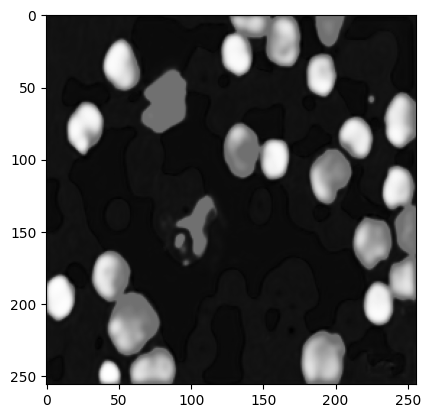

In [26]:
plt.imshow(predicted[3].permute(1, 2, 0).detach().cpu().numpy(), cmap="gray")

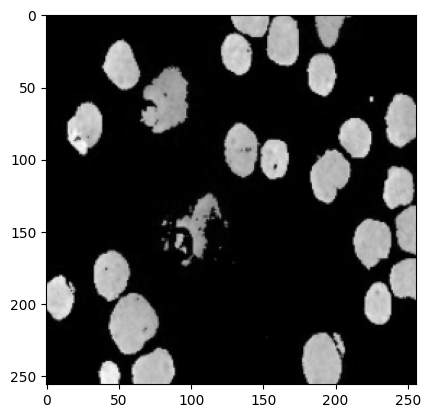

In [27]:
plt.imshow(label[3].permute(1, 2, 0).detach().cpu().numpy(), cmap="gray")